In [1]:
#| echo: false 
#| output: false
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import os 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


# Noise Scales


## The problem with naïve score approximation

With a score function approximator, we have one small issue:
in regions of low sample density,
our estimate of the score function will be inaccurate,
simply because we have few samples in those regimes.
To get around this, we can:

> perturb data points with noise 
> and train score-based models on the noisy data points instead.
> When the noise magnitude is sufficiently large, 
> it can populate low data density regions 
> to improve the accuracy of estimated scores.

There is a huge tradeoff here, though:
the larger the amount of perturbation,
the greater the corruption of the input data.
Let's see that in action.

As always, we'll start by generating some mixture Gaussian data.

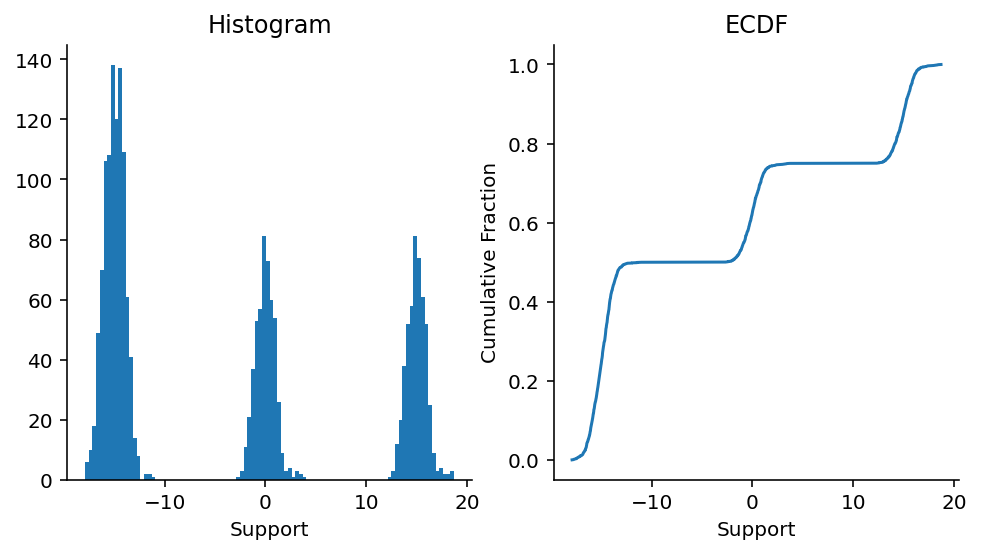

In [2]:
#| code-fold: true
#| fig-cap: Histogram and ECDF of two-component mixture Gaussian data. 
#| label: fig-data-hist-ecdf
from jax import random, vmap
import jax.numpy as np 
import matplotlib.pyplot as plt
import numpy as onp 
import seaborn as sns 

def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data) + 1) / len(data)
    return x, y

key = random.PRNGKey(45)
k1, k2, k3 = random.split(key, 3)

locations = [-15, 0, 15]

mix1 = random.normal(k1, shape=(1000,)) * 1 + locations[0]
mix2 = random.normal(k2, shape=(500,)) * 1 + locations[1]
mix3 = random.normal(k2, shape=(500,)) * 1 + locations[2]

data = np.concatenate([mix1, mix2, mix3]).reshape(-1, 1)

fig, axes = plt.subplots(figsize=(8, 4), ncols=2, sharex=True)

plt.sca(axes[0])
plt.hist(onp.array(data), bins=100)
plt.xlabel("Support")
plt.title("Histogram")

plt.sca(axes[1])
plt.plot(*ecdf(data.flatten()))
plt.xlabel("Support")
plt.ylabel("Cumulative Fraction")
plt.title("ECDF")

sns.despine()

In this case, we have intentionally spaced out the Gaussians
to create a region of extremely low density (in the approximate region $(-5, 4)$).
As we'll see later, in this region, the gradients will be really hard to estimate,
and the errors in this region may be pretty large.

Next up, we're going to perturb that data.
What we do here is add standard Gaussian draws to each data point over 5 noising steps.
Progressively, the draws should converge on a very smooth Gaussian.

In [3]:
from functools import partial 
noise_scale = np.linspace(1, 8, 9)

def noise(data, scale, key):
    draw = random.normal(key, shape=data.shape) * scale 
    return data + draw 

keys = random.split(k3, len(noise_scale))

data_perturbed = vmap(partial(noise, data))(noise_scale, keys)
data_perturbed.shape  # (num_noise_scales, num_samples, data_dim)

(9, 2000, 1)

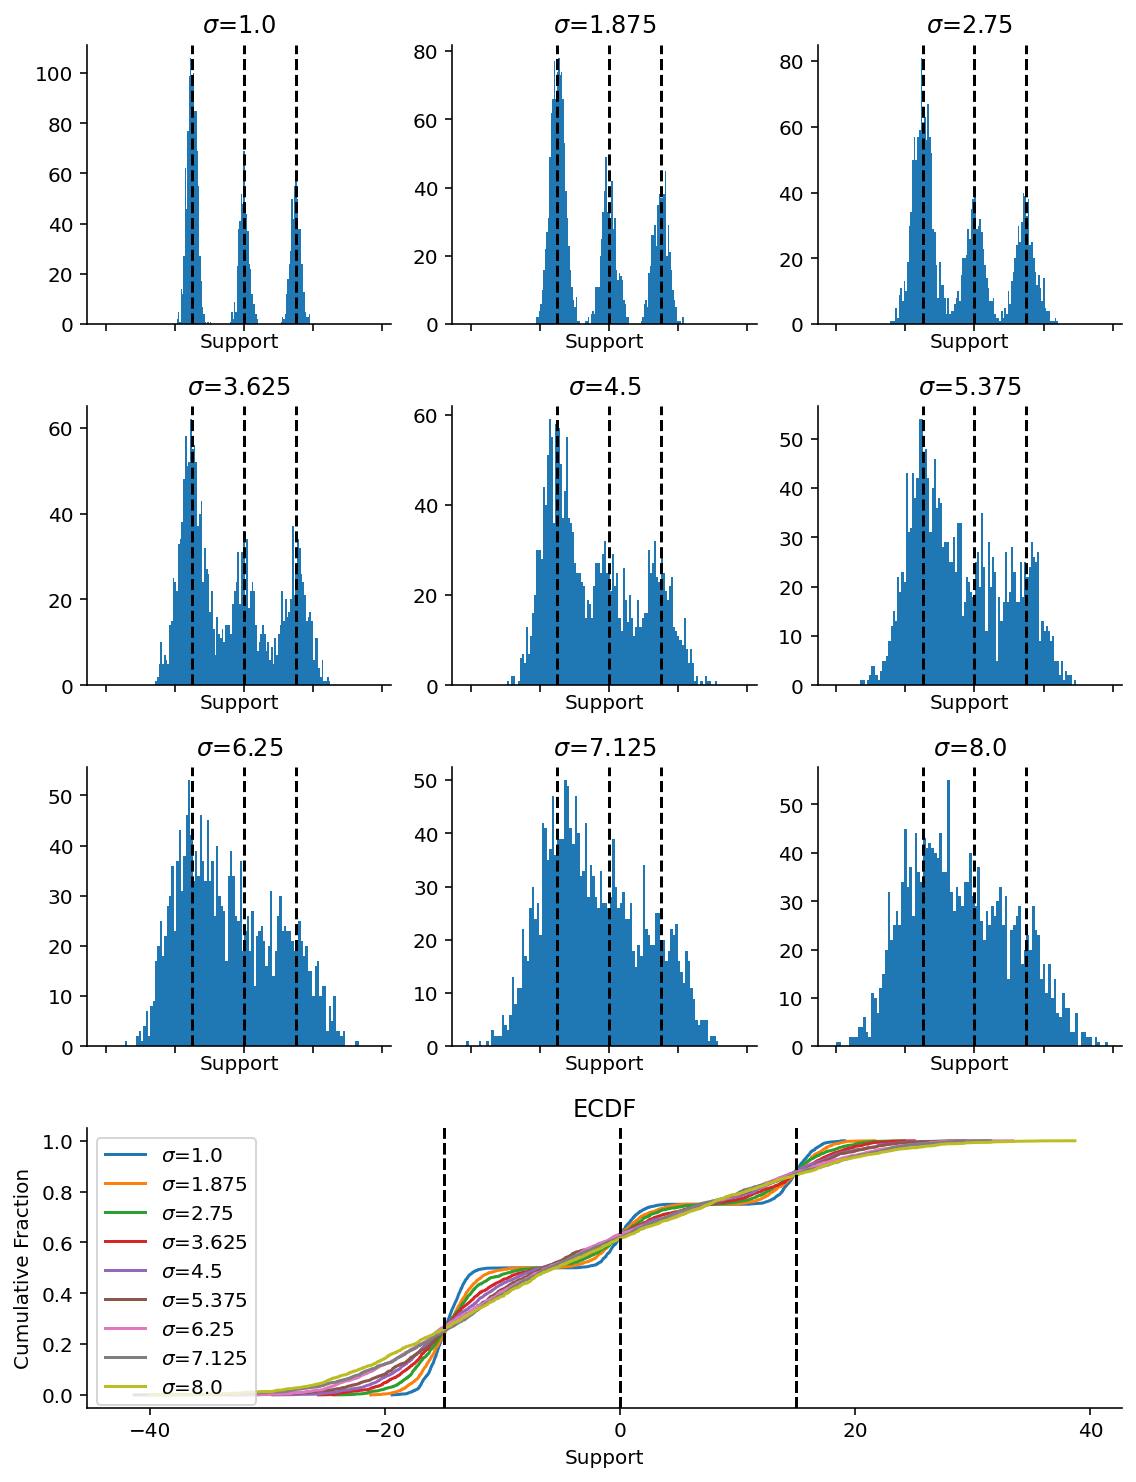

In [4]:
#| fig-cap: Distribution of samples with and without perturbation. (Top three rows) Histograms of the data. (Bottom) Empirical cumulative distribution function of samples with differing levels of perturbation.
#| label: fig-noised-data-dist
#| code-fold: true
fig, axes = plt.subplot_mosaic("""
ABC
DEF
GHI
JJJ
""",
    figsize=(8, 10.5), sharex=True)

ax_keys = "ABCDEFGHI"
for i, (row, scale, ax_key) in enumerate(zip(data_perturbed, noise_scale, ax_keys)):
    plt.sca(axes[ax_key])
    plt.hist(onp.array(row.flatten()), bins=100)
    plt.title(f"$\sigma$={scale}")
    plt.xlabel("Support")
    for loc in locations: 
        plt.axvline(loc, color="black", ls="--")

plt.sca(axes["J"])
for row, scale in zip(data_perturbed, noise_scale):
    plt.plot(*ecdf(row.flatten()), label=f"$\sigma$={scale}")
    for loc in locations: 
        plt.axvline(loc, color="black", ls="--")

plt.legend()
plt.xlabel("Support")
plt.ylabel("Cumulative Fraction")
plt.title("ECDF")

sns.despine()
plt.tight_layout()

Should be evident from the figure above
that when we add more noise, the data look more and more like a single Gaussian
and less like the original.
Most crucially, in the regions of low density between the two mixture Gaussians
(the flat regime in the blue line),
we have a region of high density in the perturbed distributions
(the red line in the same region).
We should be able to obtain accurate score models 
for the perturbed data in the regime of low density support (on the blue curve).
As we will see later, 
this will help us obtain slightly more accurate score models
for the blue curve's flat region.
In theory, if we were to reverse the process,
we should get back our original data distribution.

## Sampling using the score function


OK! With this, we are now ready to start sampling!
This is the logic that we're going to follow.
We know that the last perturbation's score models 
are going to be more accurate on the perturbed distribution,
but it's also going to be less accurate about the original distribution.
To recap, we're going to need a score model 
that approximates the score function of our data
and a Langevin dynamics sampler for generating new data.


### Train Score Model

As always, we train the score model.

In [5]:
from score_models.training import fit
from score_models.models import FeedForwardModel1D
from score_models.losses import score_matching_loss
from score_models.sampler import LangevinDynamicsChain
from jax import nn
import optax
from functools import partial

ffmodel = FeedForwardModel1D(depth=2, width_size=512, activation=nn.softplus)
optimizer = optax.chain(
    optax.adam(learning_rate=5e-3),
)

updated_model, history = fit(
    ffmodel, data, score_matching_loss, optimizer, 2_000, progress_bar=True
)


  0%|          | 0/2000 [00:00<?, ?it/s]

### Sample

Then, we sample new data using the score function coupled with a Langevin dynamics sampler.

In [6]:
n_particles = 20_000
starter_points = random.normal(key, shape=(n_particles, 1, 1)) * 10
starter_keys = random.split(key, n_particles)
trained_model_sampler = LangevinDynamicsChain(
    gradient_func=updated_model, n_samples=100, epsilon=5e-1
)
final_non_joint, trained_samples = vmap(trained_model_sampler)(starter_points, starter_keys)


### Visualize the samples

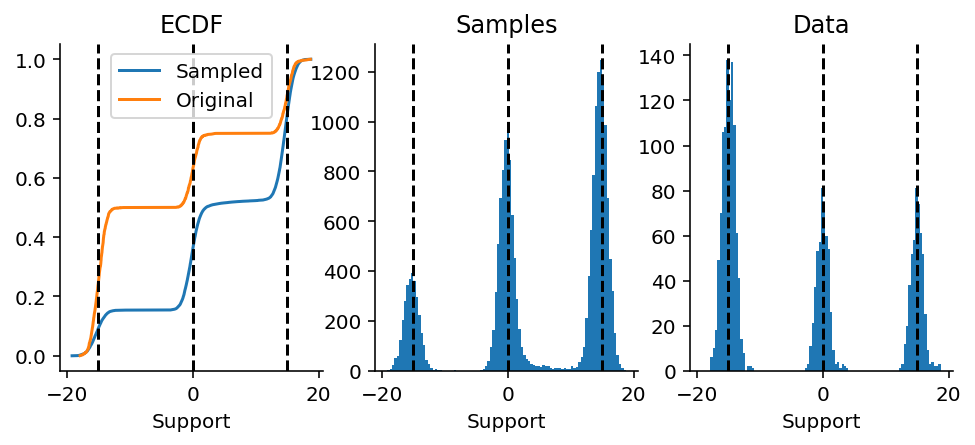

In [7]:
#| code-fold: true
#| fig-cap: Final samples from 10,000 particles run for 100 sampling steps, shown as (a) a histogram, and (b) an ECDF alongside the original data.
#| label: fig-samples-10kparticles-100steps
fig, axes = plt.subplots(figsize=(8, 3), ncols=3, nrows=1, sharex=True)

plt.sca(axes[0])
plt.plot(*ecdf(final_non_joint.flatten()), label="Sampled")
plt.plot(*ecdf(data.flatten()), label="Original")
for loc in locations: 
    plt.axvline(loc, color="black", ls="--")

plt.xlabel("Support")
plt.title("ECDF")
plt.legend()

plt.sca(axes[1])
plt.hist(onp.array(final_non_joint.flatten()), bins=100)
for loc in locations: 
    plt.axvline(loc, color="black", ls="--")
plt.xlabel("Support")
plt.title("Samples")

plt.sca(axes[2])
plt.hist(onp.array(data.flatten()), bins=100)
for loc in locations: 
    plt.axvline(loc, color="black", ls="--")
plt.xlabel("Support")
plt.title("Data")

sns.despine()

OK, yes, we're able to!
Looking at the distributions,
notice how the mixture weights are a bit different between the samples and the data.
However, we should notice that the middle Gaussian has a long tail of samples.
This implies something wrong with gradient estimation.
The problem here is either due to a lack of training budget (2,000 steps only)
or because it is genuinely difficult to estimate gradients in that regime.
The latter is what Yang Song states as the main issue.

Let's also do a side-by-side comparison of gradients for the original data 
v.s. the true score function of the mixture model.

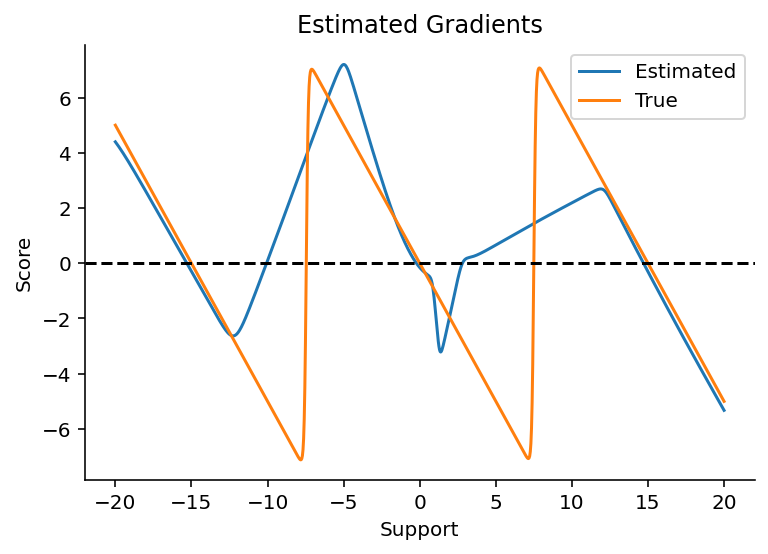

In [8]:
#| fig-cap: Estimated gradients for the original data.
#| label: fig-est-grads-original
#| code-fold: true
from score_models.models.gaussian import MixtureGaussian

support = np.linspace(-20, 20, 1000).reshape(-1, 1)
gradients = vmap(updated_model)(support)
plt.plot(support, gradients, label="Estimated")

true_score_func = MixtureGaussian(
    mus=np.array(locations),
    log_sigmas=np.log(np.array([1.0, 1.0, 1.0])),
    ws=np.array([0.5, 0.25, 0.25]),
)
original_gradients = vmap(true_score_func)(support).squeeze()
plt.plot(support, original_gradients, label="True")
plt.legend()

plt.title("Estimated Gradients")
plt.xlabel("Support")
plt.ylabel("Score")
plt.axhline(y=0, color="black", ls="--")
plt.legend()
sns.despine()


The gradients diagnostic here should also be quite illuminating.
In particular, there are regions where the gradient estimation is way off.
That is where the next point might come in handy.

## One score model per perturbation

One key idea in Yang Song's blog post
is that we can jointly train score models for each of the noise levels
and then use Langevin dynamics in an annealed fashion
to progressively obtain better and better samples from the original data distribution.
The loss function here is a _weighted sum of Fisher divergences_,
or, more simply, a sum of score model losses
weighted by the noise scale applied to the data.
The intuition here is that we weigh more heavily the strongly perturbed data
and weigh less heavily the weakly perturbed data,
because the score model will be more accurate for the strongly perturbed data.
Thinking downstream two steps, we will be using a procedure called _annealed Langevin dynamics_
to sample from this mixture Gaussian, such that 
In our example, we will have a batch of models trained with a single loss function,
one for each scale value,
which is the weighted sum of Fisher divergences,

In [9]:
from functools import partial 

Firstly, we start with a `vmap`-ed version of our model.
This will make it easy for us to train a batch of models together.

In [10]:
from pyprojroot import here 
import cloudpickle as pkl

def make_model(key):
    ffmodel = FeedForwardModel1D(
        depth=2, width_size=512, activation=nn.softplus, key=key
    )
    return ffmodel

key = random.PRNGKey(49)
keys = random.split(key, len(noise_scale))
models = []
for key in keys:
    models.append(make_model(key))


Next, we define our joint loss function.
Here, the loss function is a weighted sum of score matching losses.
In related body of work, the greater the noise scale, the higher the weight.
The intuition here is that gradients are more accurately estimated at higher noise scales,
while gradients are less accurately estimated at lower noise scales.
For fairness in comparison, we will use the same number of training steps are before
for independently-trained models.

In [11]:
from score_models.losses import joint_score_matching_loss

optimizer = optax.chain(
    optax.clip(0.1),
    optax.adam(5e-3),
)

(here() / "artifacts").mkdir(exist_ok=True)

n_steps = 2_000

artifact_path = here() / f"artifacts/noise_scale_model_{n_steps}.pkl"
updated_models, training_history = fit(
    models,
    data_perturbed,
    partial(joint_score_matching_loss, scales=noise_scale),
    optimizer=optimizer,
    steps=n_steps,
)
with open(artifact_path, "wb") as f:
    pkl.dump((updated_models, training_history), f)


  0%|          | 0/2000 [00:00<?, ?it/s]

## Confirm sampling works after joint training

We're now going to do a quick sanity-check:
our trained score models should be usable to sample from the mixture distribution.
Let's confirm that before proceeding.

In [12]:
n_particles = 1_000
starter_points = random.normal(key, shape=(n_particles, 1, 1)) * 10
starter_keys = random.split(key, n_particles)
trained_model_sampler = LangevinDynamicsChain(
    gradient_func=updated_models[0], n_samples=100, epsilon=5e-1
)
final, trained_samples = vmap(trained_model_sampler)(starter_points, starter_keys)

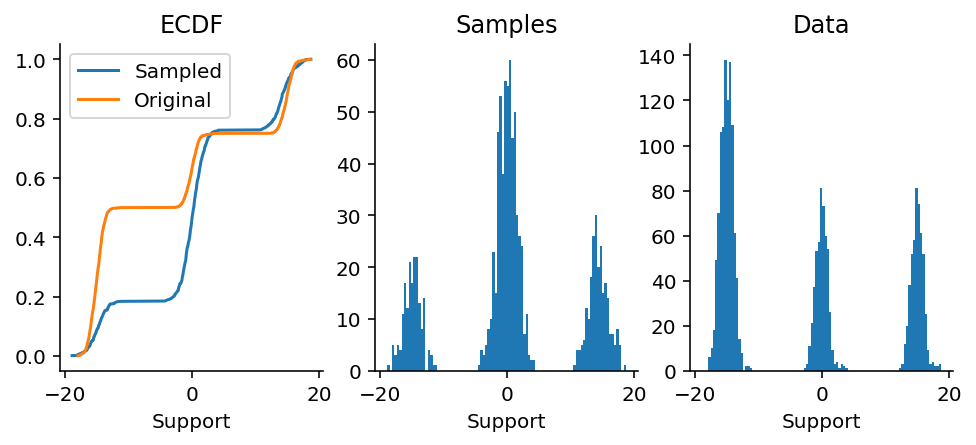

In [13]:
#| code-fold: true
#| fig-cap: Sanity check of sampling. (left) ECDF of samples vs. original data. Histogram of (middle) samples and (right) original data are also shown.
#| label: fig-sampling-sanity-check.
fig, axes = plt.subplots(figsize=(8, 3), ncols=3, nrows=1, sharex=True)

plt.sca(axes[0])
plt.plot(*ecdf(final.flatten()), label="Sampled")
plt.plot(*ecdf(data.flatten()), label="Original")
plt.xlabel("Support")
plt.title("ECDF")
plt.legend()

plt.sca(axes[1])
plt.hist(onp.array(final.flatten()), bins=100)
plt.xlabel("Support")
plt.title("Samples")

plt.sca(axes[2])
plt.hist(onp.array(data.flatten()), bins=100)
plt.xlabel("Support")
plt.title("Data")

sns.despine()

## Annelaed Langevin Dynamics Sampling

Annealed Langevin dynamics sampling is a way to get around the problem 
of poorly estimated gradients in low density regions.
The procedure is rather simple and elegant.
We start by performing Langevin dynamics sampling at the highest noise value.
After a fixed number of steps,
we freeze the samples and use them as the starting point
for sampling at the next highest noise value,
progressively stepping down the noise until we hit the unperturbed data.
In doing so, we ensure that the score function can be progressively estimated
around regions of high density
while progressively worrying less and less about the low density gradients.

In [14]:
n_particles = 10_000
starter_points = random.normal(key, shape=(n_particles, 1, 1)) * 10
starter_keys = random.split(key, n_particles)

final_points_history = []
for model in updated_models[::-1]:
    trained_model_sampler = LangevinDynamicsChain(
        gradient_func=model, n_samples=100, epsilon=5e-1
    )
    final_points, trained_samples = vmap(trained_model_sampler)(starter_points, starter_keys)
    final_points_history.append(final_points)
    starter_points = final_points

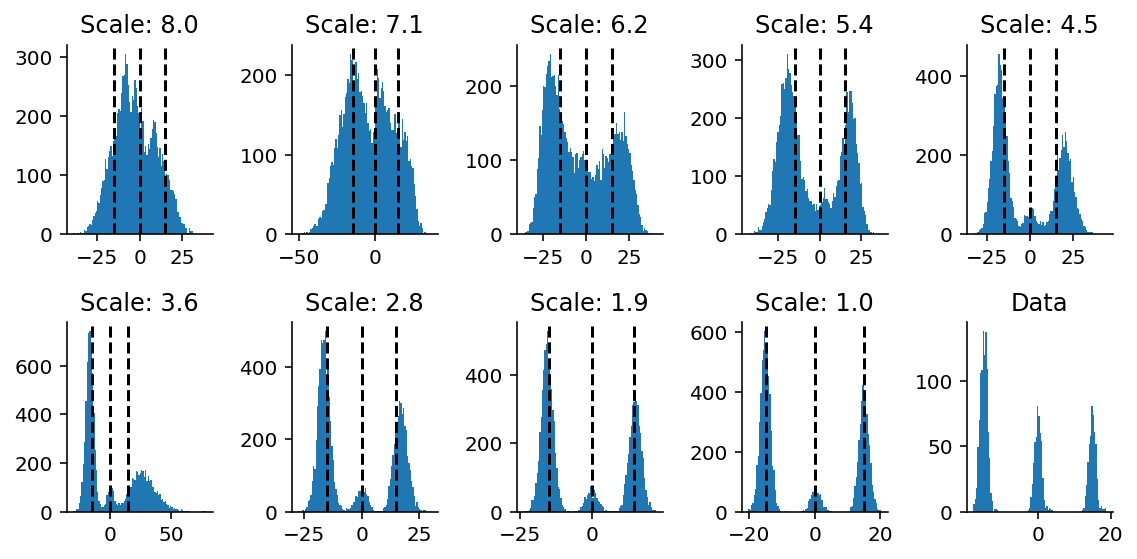

In [15]:
#| code-fold: true 
#| fig-cap: Annealed Langevin dynamics samples at varying noise scales. Data (bottom-right) is shown for comparison.
#| label: fig-annealed-langevin-dynamics-samples
fig, axes = plt.subplots(figsize=(8, 4), ncols=5, nrows=2, sharey=False)
axes = axes.flatten()

for ax, history, scale in zip(axes, final_points_history, noise_scale[::-1]):
    plt.sca(ax)
    plt.hist(onp.array(history.flatten()), bins=100)
    plt.title(f"Scale: {scale:.1f}")
    for loc in locations:
        plt.axvline(x=loc, ls="--", color="black")

plt.sca(axes[-1])
plt.hist(onp.array(data.flatten()), bins=100)
plt.title("Data")
sns.despine()
plt.tight_layout()

Let's also compare samples taken from jointly trained vs. independently trained models
alongside their estimated score functions.

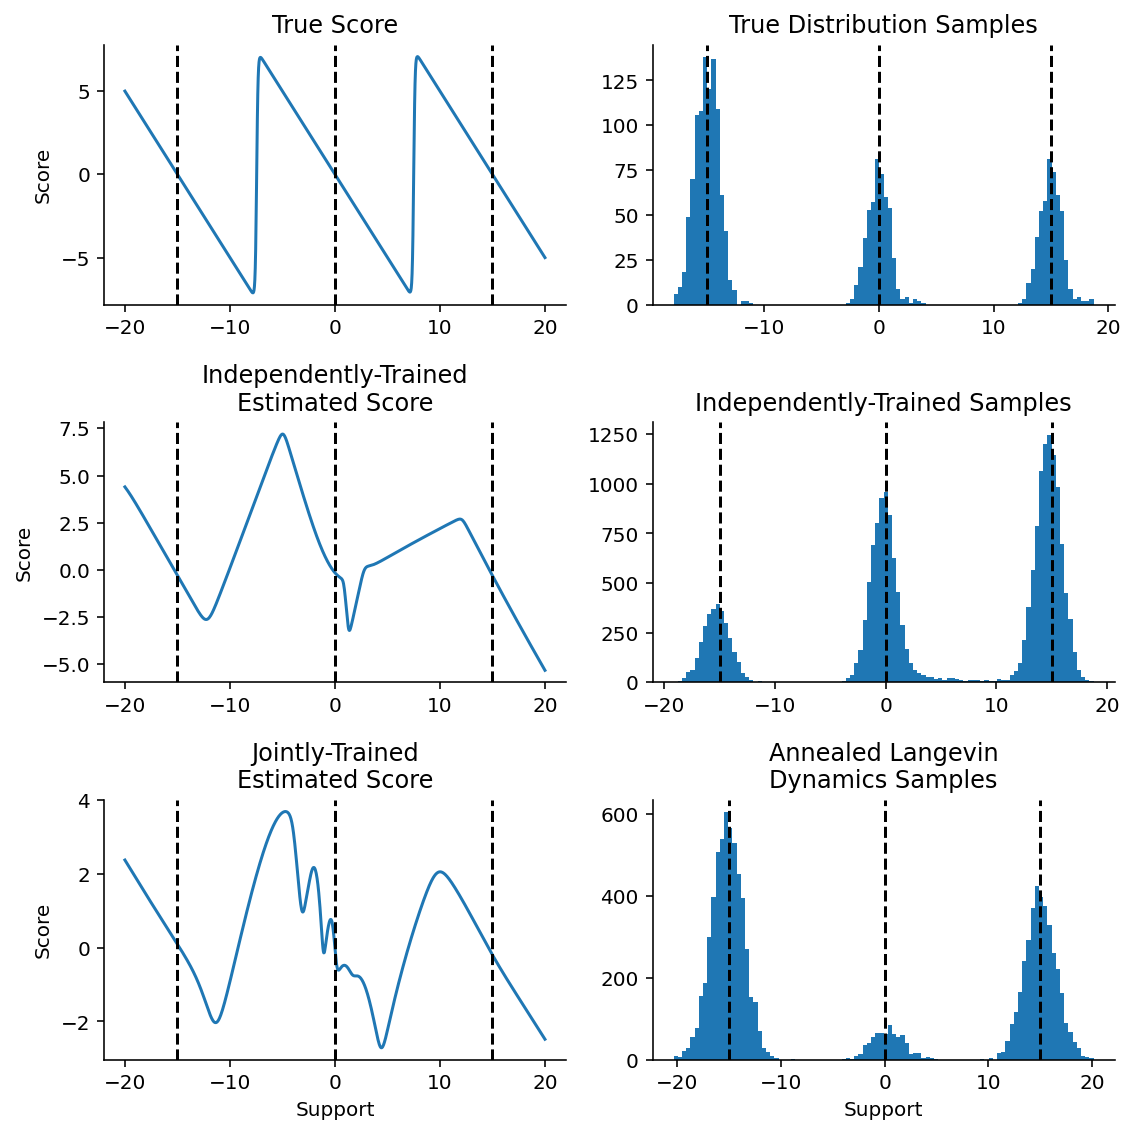

In [16]:
#| code-fold: true
#| fig-cap: Comparison between true (top), independently trained (middle) and jointly trained (bottom) score models. (left) Score models evaluated along the support. (right) Samples drawn from true distribution (right-top) and by Langevin dynamics sampling (right middle and right bottom).
#| label: fig-comparison
support = np.linspace(-20, 20, 1000).reshape(-1, 1)

fig, axes = plt.subplot_mosaic("""
AD
AD
BE
BE
CF
CF
""", figsize=(8, 8))
# First subplot: show gradients for noise scale 1.0 and for ground truth.
plt.sca(axes["A"])
true_score = vmap(true_score_func)(support.squeeze())
plt.plot(support, true_score, label="True")
plt.title("True Score")
plt.ylabel("Score")

plt.sca(axes["B"])
independent_score = vmap(updated_model)(support)
plt.plot(support, independent_score, label="Independent")
plt.title("Independently-Trained\nEstimated Score")
plt.ylabel("Score")

plt.sca(axes["C"])
joint_score = vmap(updated_models[0])(support)
plt.plot(support, joint_score, label="Joint")
plt.title("Jointly-Trained\nEstimated Score")
plt.xlabel("Support")
plt.ylabel("Score")

plt.sca(axes["D"])
plt.hist(onp.array(data.flatten()), bins=100)
plt.title("True Distribution Samples")

plt.sca(axes["E"])
plt.hist(onp.array(final_non_joint.flatten()), bins=100)
plt.title("Independently-Trained Samples")

plt.sca(axes["F"])
plt.hist(onp.array(final_points_history[-1].flatten()), bins=100)
plt.title("Annealed Langevin\nDynamics Samples")
plt.xlabel("Support")

for axname, ax in axes.items():
    plt.sca(ax)
    for loc in locations:
        plt.axvline(x=loc, ls="--", color="black")

plt.tight_layout()
sns.despine()

While it's tempting to look at the peaks, the region of low density is where we should focus our attention.
In the middle row's samples, we see that the independently-trained model
has a long tail of density between the middle component and the right component,
something that is missing in the true distribution's draws and in the annealed samples.
The same can be seen on the left side, where we see the estimated score function
taking on a rather inaccurate shape in that low density regime.